## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models import FCN

from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/fcn")
data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

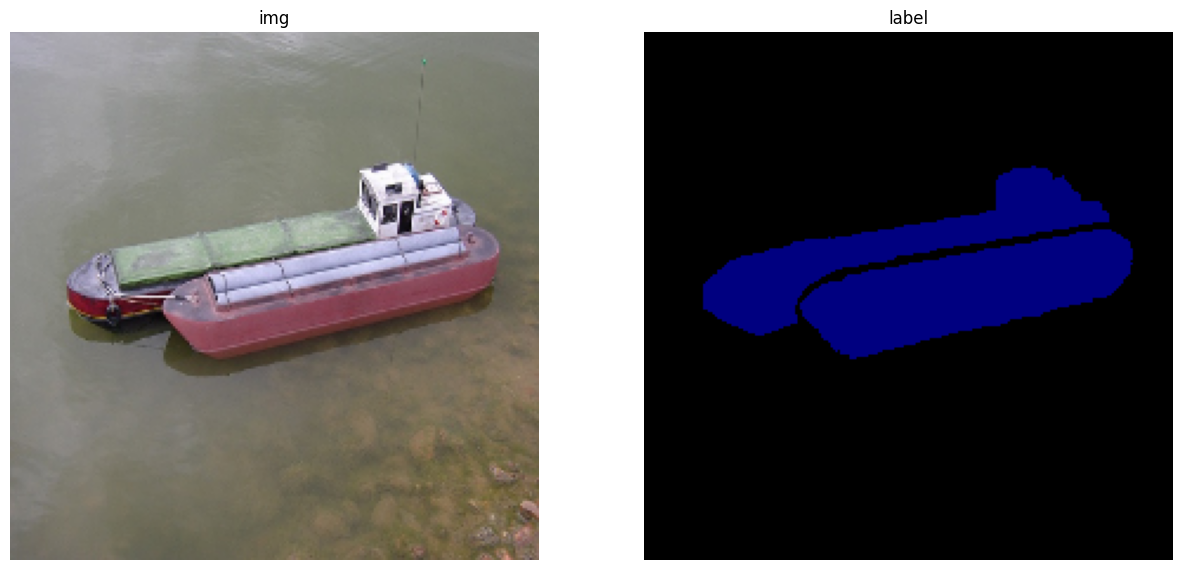

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [10]:
EPOCHES = 5

In [11]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [12]:
criterion = trainer.get_criterion(NUM_CLASS)

In [13]:
prev_model = None
for num_skip_connection in range(1, 4):
    model = FCN(NUM_CLASS + 1, num_skip_connection=num_skip_connection, frozen_backbone=True).to(DEVICE)
    if num_skip_connection > 1:
        model.backbone = prev_model.backbone
        model.conv = prev_model.conv
        for _ in range(num_skip_connection - 1):
            model.pool_convs.pop(0)
        for i in range(num_skip_connection - 1):
            model.pool_convs.insert(i, prev_model.pool_convs.pop(0))
        if num_skip_connection > 2:
            for _ in range(num_skip_connection - 2):
                model.upsamples.pop(0)
            for i in range(num_skip_connection - 2):
                model.upsamples.insert(i, prev_model.upsamples.pop(0))
        # print(model.pool_convs, model.upsamples)
    optimizer = torch.optim.Adam(model.parameters(), lr=[1e-3, 1e-4, 5e-5][num_skip_connection-1])
    training_loss = trainer.run(train_loader, model, optimizer, criterion)
    if num_skip_connection < 3:
        prev_model = model

100%|██████████| 182/182 [00:45<00:00,  4.00it/s]


epoch 1 : 0.07607333284321723


100%|██████████| 182/182 [00:48<00:00,  3.72it/s]


epoch 2 : 0.04348120108697113


100%|██████████| 182/182 [00:49<00:00,  3.66it/s]


epoch 3 : 0.03281706083402201


100%|██████████| 182/182 [00:49<00:00,  3.68it/s]


epoch 4 : 0.027333684112098845


100%|██████████| 182/182 [00:49<00:00,  3.69it/s]


epoch 5 : 0.023855315388313363
ModuleList(
  (0): Conv2d(4096, 21, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
) ModuleList(
  (0): UpSampling(
    (conv): Sequential(
      (0): ConvTranspose2d(21, 21, kernel_size=(4, 4), stride=(2, 2), bias=False)
    )
  )
  (1): UpSampling(
    (conv): Sequential(
      (0): ConvTranspose2d(21, 21, kernel_size=(32, 32), stride=(16, 16), bias=False)
    )
  )
)


100%|██████████| 182/182 [00:48<00:00,  3.74it/s]


epoch 1 : 0.056876679452566


100%|██████████| 182/182 [00:48<00:00,  3.78it/s]


epoch 2 : 0.02399714962978448


100%|██████████| 182/182 [00:48<00:00,  3.75it/s]


epoch 3 : 0.020219596701541116


100%|██████████| 182/182 [00:47<00:00,  3.81it/s]


epoch 4 : 0.017812346768371023


100%|██████████| 182/182 [00:47<00:00,  3.85it/s]


epoch 5 : 0.01626688342766611
ModuleList(
  (0): Conv2d(4096, 21, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
  (2): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
) ModuleList(
  (0-1): 2 x UpSampling(
    (conv): Sequential(
      (0): ConvTranspose2d(21, 21, kernel_size=(4, 4), stride=(2, 2), bias=False)
    )
  )
  (2): UpSampling(
    (conv): Sequential(
      (0): ConvTranspose2d(21, 21, kernel_size=(16, 16), stride=(8, 8), bias=False)
    )
  )
)


100%|██████████| 182/182 [00:44<00:00,  4.05it/s]


epoch 1 : 0.07269656744140846


100%|██████████| 182/182 [00:47<00:00,  3.87it/s]


epoch 2 : 0.026916917474879013


100%|██████████| 182/182 [00:49<00:00,  3.71it/s]


epoch 3 : 0.01647882644537386


100%|██████████| 182/182 [00:46<00:00,  3.96it/s]


epoch 4 : 0.0140937799920461


100%|██████████| 182/182 [00:43<00:00,  4.23it/s]

epoch 5 : 0.012676863324736337


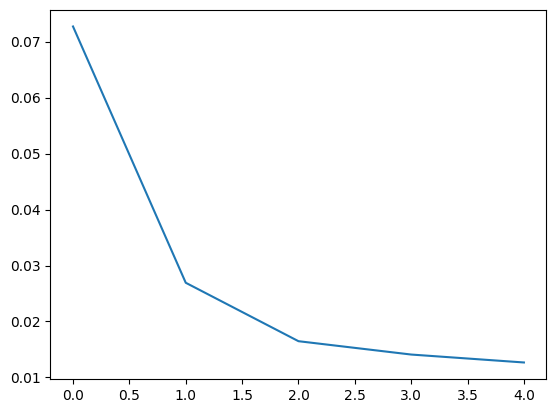

In [14]:
plt.plot(training_loss)

In [15]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
FCN                                           --
├─VggFeatureExtractor: 1-1                    --
│    └─ImageNetNormalization: 2-1             --
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15  

In [16]:
model_path = artifacts_path.joinpath('fcn.pth')

In [17]:
torch.save(model.state_dict(), model_path)

In [18]:
get_file_size(model_path)

'513.05MiB'

In [19]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [86]:
# from torchmetrics.classification import jaccard

In [20]:
# metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1)

model.eval()
with torch.no_grad():
    dice = {class_idx: [] for class_idx in range(21)}
    for img, labels in tqdm(test_loader):
        img = img.cuda()

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        img = img.detach().cpu()

        for class_idx in range(21):
            coef = 2 * (output.eq(class_idx) * labels.eq(class_idx)).sum() / (1 + output.eq(class_idx).sum() + labels.eq(class_idx).sum())
            dice[class_idx].append(coef) 
        # metric.update(output, labels)

for k, v in dice.items():
  dice[k] = np.mean(v)

100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


In [88]:
# metric.compute()

tensor(0.4345)

In [21]:
dice.pop(0, "")

# show dice of each category
for k, v in dice.items():
    print(VOC_CLASS_NAMES[k-1], v)

# show all
print("mean dice:", np.mean(list(dice.values())))

aeroplane 0.43325835
bicycle 0.12058797
bird 0.48429656
boat 0.42975768
bottle 0.22436221
bus 0.48666802
car 0.4581214
cat 0.63624173
chair 0.17610805
cow 0.3840672
diningtable 0.5774908
dog 0.5624172
horse 0.46635804
motorbike 0.47570205
person 0.8343237
pottedplant 0.17518353
sheep 0.42706648
sofa 0.4338154
train 0.54454887
tvmonitor 0.41036424
mean dice: 0.43703693


### for image in dataset

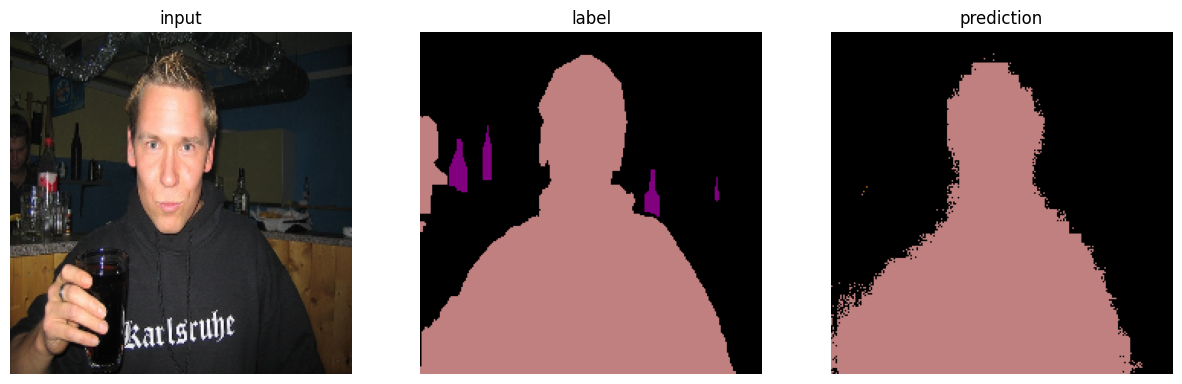

In [24]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

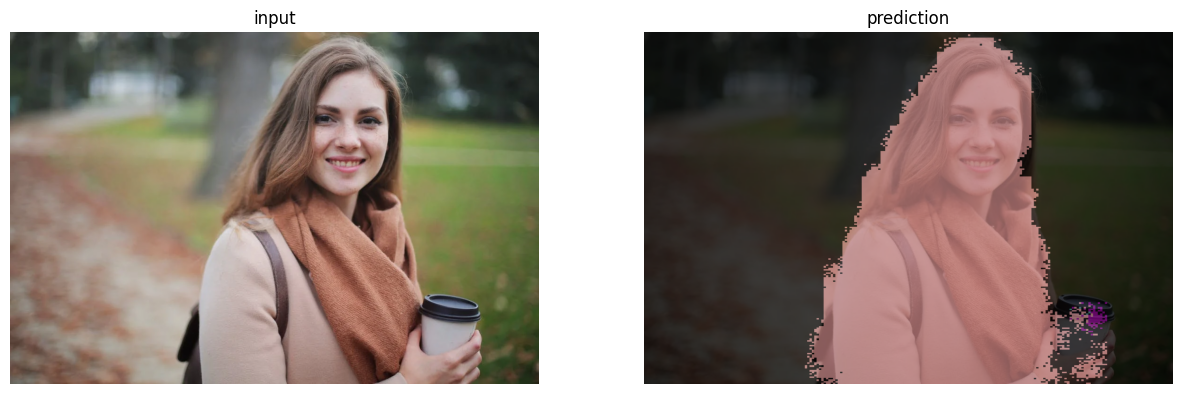

In [23]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )